# 4. 프로젝트: CutMix 또는 Mixup 비교 실험하기

augmentation의 적용 유무에 따른 ResNet50 분류기의 견종 분류 정확도 성능을 비교해보자.

augmentation을 적용 유무의 경우의 수는 다음과 같다.

- Augmentation을 적용하지 않은 basic 데이터셋
- Augmentation을 적용한 데이터셋
- Augmentation과 CutMix를 적용한 데이터셋
- Augmentation과 Mixup을 적용한 데이터셋

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1) 데이터셋 준비하기

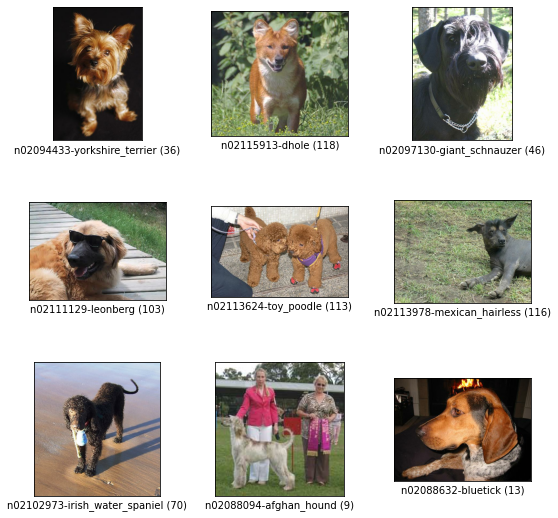

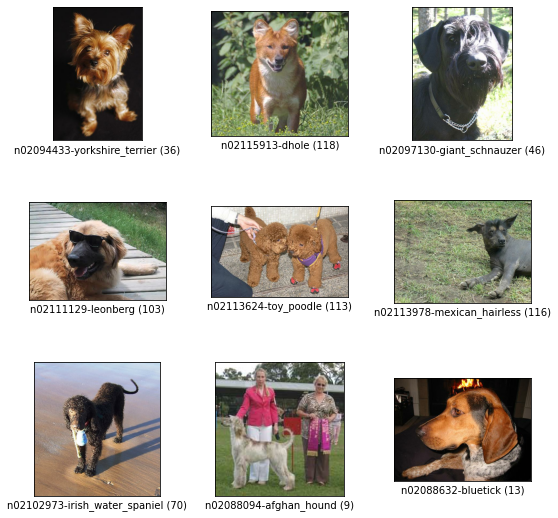

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

# 2) Augmentation, CutMix, MixUp 적용하기

In [5]:
# normalize, resize
def normalize_and_resize_img(image, label): 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

### 2-1) augmentation

In [6]:
# augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1) # brightness로 변한 image 텐서 값을 0~1 사이로 맞춘다.
    return image, label

### 2-2)CutMix

`image_a`를 바탕으로 하고 거기에 삽입할 `image_b`를 넣어야 하는 작업이 필요하다.   
image의 bounding box를 정하는 `get_clip_box()`,   
두 이미지를 섞어줄 `mix_2_images()`,   
이미지 섞은 비율과 맞게 라벨 섞어줄 `mix_2_labels`을 선언하자.

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [8]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 2-3) MixUp

두 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식이다.   


In [11]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 2-4) 적용하기

In [13]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    
    # image normalize, resize
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2 # 병렬 처리
    )
    if not is_test and with_aug: # train에 augmentation 적용
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # train에 cutmix 적용
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: # train에 mixup 적용
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 3) resnet50 모델 불러오기

ResNet50의 imagenet을 가중치로 불러오자.   
augmentation 적용 여부와 cutmix, mixup 적용 전후의 성능을 따져야 하기 때문에 4개의 모델을 선언하자.

In [15]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [16]:
# Augmentation을 적용하지 않은 basic 데이터셋
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 마지막 FC layer 포함 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
# Augmentation을 적용한 데이터셋
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
# Augmentation과 CutMix를 적용한 데이터셋
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
# Augmentation과 mixup을 적용한 데이터셋
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# 4) 학습

In [21]:
EPOCH = 20

In [22]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 104s 121ms/step - loss: 2.2083 - accuracy: 0.4495 - val_loss: 3.2563 - val_accuracy: 0.2334
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 0.7014 - accuracy: 0.8079 - val_loss: 1.1127 - val_accuracy: 0.6721
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2113 - accuracy: 0.9589 - val_loss: 0.9498 - val_accuracy: 0.7210
Epoch 4/20
750/750 [==============================] - 90s 119ms/step - loss: 0.0747 - accuracy: 0.9928 - val_loss: 0.9369 - val_accuracy: 0.7290
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0547 - accuracy: 0.9948 - val_loss: 0.9525 - val_accuracy: 0.7320
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0183 - accuracy: 0.9992 - val_loss: 0.9314 - val_accuracy: 0.7410
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0096 - accuracy: 0.9999 - val_loss: 0.9335 - val_accuracy: 0.

In [23]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 99s 120ms/step - loss: 2.2820 - accuracy: 0.4308 - val_loss: 2.8006 - val_accuracy: 0.3045
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.9173 - accuracy: 0.7354 - val_loss: 1.2383 - val_accuracy: 0.6481
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.4810 - accuracy: 0.8729 - val_loss: 1.1106 - val_accuracy: 0.6804
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2341 - accuracy: 0.9484 - val_loss: 1.0718 - val_accuracy: 0.6962
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1260 - accuracy: 0.9784 - val_loss: 1.0227 - val_accuracy: 0.7125
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0715 - accuracy: 0.9899 - val_loss: 0.9763 - val_accuracy: 0.7274
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0525 - accuracy: 0.9923 - val_loss: 1.1012 - val_accuracy: 0.6

In [28]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # augmentation, cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 97s 121ms/step - loss: 1.6068 - accuracy: 0.8058 - val_loss: 1.2989 - val_accuracy: 0.7042
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 1.5728 - accuracy: 0.8103 - val_loss: 1.4296 - val_accuracy: 0.6806
Epoch 3/20
750/750 [==============================] - 96s 128ms/step - loss: 1.5118 - accuracy: 0.8232 - val_loss: 1.3342 - val_accuracy: 0.7003
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 1.5065 - accuracy: 0.8271 - val_loss: 1.4631 - val_accuracy: 0.6761
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 1.4932 - accuracy: 0.8166 - val_loss: 1.3897 - val_accuracy: 0.6800
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 1.4811 - accuracy: 0.8263 - val_loss: 1.5345 - val_accuracy: 0.6528
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 1.4810 - accuracy: 0.8232 - val_loss: 1.4371 - val_ac

In [25]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_resnet50.fit(
    ds_train_mixup, # augmentation, mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 98s 122ms/step - loss: 1.8916 - accuracy: 0.8297 - val_loss: 1.3669 - val_accuracy: 0.6804
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 1.8741 - accuracy: 0.8310 - val_loss: 1.4217 - val_accuracy: 0.6680
Epoch 3/20
750/750 [==============================] - 92s 122ms/step - loss: 1.8279 - accuracy: 0.8369 - val_loss: 1.5744 - val_accuracy: 0.6323
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 1.8020 - accuracy: 0.8432 - val_loss: 1.3724 - val_accuracy: 0.6786
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 1.7549 - accuracy: 0.8506 - val_loss: 1.3535 - val_accuracy: 0.6830
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 1.7766 - accuracy: 0.8505 - val_loss: 1.3379 - val_accuracy: 0.6831
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 1.7485 - accuracy: 0.8598 - val_loss: 1.4904 - val_accuracy: 0.6

# 5) 결과 시각화

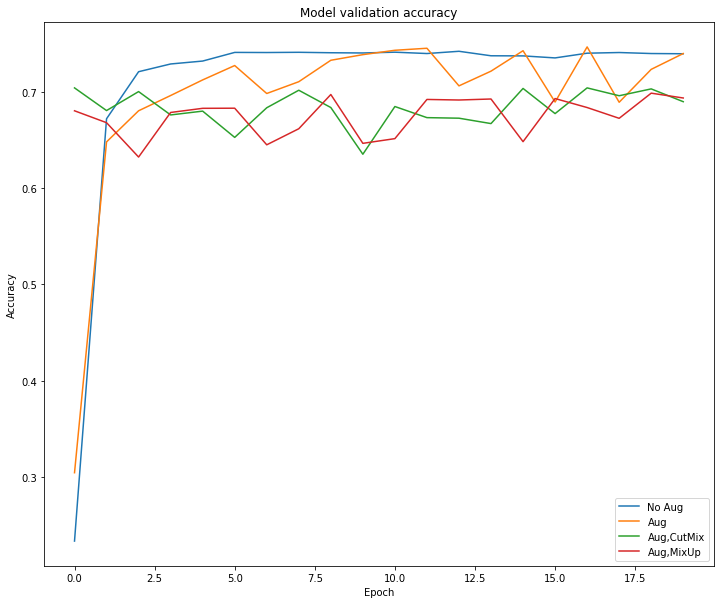

In [29]:
plt.figure(figsize=(12, 10))

plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug','Aug,CutMix','Aug,MixUp'])
plt.show()

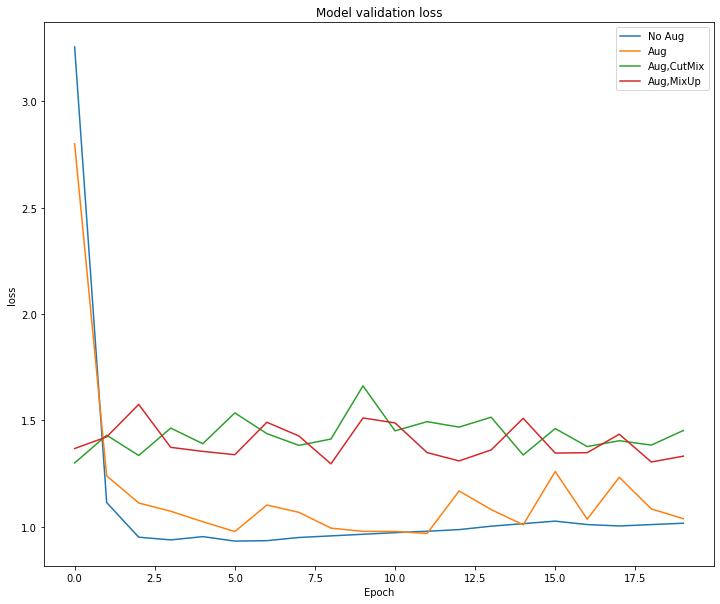

In [30]:
plt.figure(figsize=(12, 10))

plt.plot(history_resnet50_no_aug.history['val_loss'])
plt.plot(history_resnet50_aug.history['val_loss'])
plt.plot(history_resnet50_aug_cutmix.history['val_loss'])
plt.plot(history_resnet50_aug_mixup.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug','Aug,CutMix','Aug,MixUp'])
plt.show()

# 최종 정리
결과는 예상과 달리 augmentation을 넣지 않은 데이터셋이 결과가 가장 좋게 나왔다.   
하지만 accuracy를 보면 2.5 에포크부터 천천히 낮아지고 있고, basic한 augmenation을 적용한 데이터셋이 천천히 좋아지고 있다. 30에포크정도 까지 학습을 시키고 dropout을 추가한다면, augmentation을 넣은 결과가 더 크게 좋아질거같다.

하지만 모든 augmentation이라 좋은건 아니다.   
cutmix, mixup 둘 다 좋지 않은 성능을 내고 있으며, 천천히 우상향 하   
모델이 저렇게 이질적인 방법으로 합성된 이미지를 학습 하는데, 이러한 방식을 학습하기엔 20에포크는 부족한거같다. 적어도 50 에포크 정도는 학습해야 적용 유무에 대한 확실한 결과를 제대로 알거같다.   
그렇다고 epoch가 커진다고 좋은 성능을 낸다는 보장이 없어, 효율적이지 않은 augmentation 방법인거같다.